Download books of two authors from the Gutenberg Project
Use HC scores to attribute each book to the corpus of its author.

Require packages 'gutenberg' and 'plotnine'

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

#import auxiliary functions for python
import sys

import sys
sys.path.append('../')
from AuthAttLib import *
from visualize_HC_scores import *

%matplotlib inline
from gutenberg.acquire import load_etext
from gutenberg.cleanup import strip_headers

<H1> Dicknes vs Austin </H1>

Run `Download_Dicknes_Austin.py' to create 'Dickens.csv' and 'Ausin.csv'

<H3> Prepare data, remove header, clean symbols and digits</H3>

In [2]:
from text_processing import *

def clean_text(data) :
    HEADER = 1000 # remove first 1000 words, usually contains header information
    data.text = data.text.apply(lambda x : " ".join(x.split()[HEADER:])) #trim header
    data.text = data.text.apply(remove_hexa_symbols)
    data.text = data.text.apply(remove_digits)
    data.text = data.text.apply(remove_CR_LF)
    data = data.filter(['author', 'title', 'text']).rename(columns = {'title' : 'doc_id'})
    return data

Dickens_corpus = pd.read_csv('../Data/Dickens.csv')
Austin_corpus = pd.read_csv('../Data/Austin.csv')

data = pd.concat([clean_text(Dickens_corpus),
                  clean_text(Austin_corpus)])


<H3>Remove parts of speech to useful for author separation (optional)</H3>
(takes 10-20 min)

In [3]:
def remove_POS(text) :
    try :
        tx = remove_parts_of_speach(text,
                        to_remove = ('NNP','NNPS','PRP','PRP$','CD'),
                        lemmatize = False)
    # 'NNP'-- proper noun, singluar
    # 'NNPS' -- proper noun, plural 
    # 'CD' -- cardinal digit
    # 'PRP' -- personal pronoun
    # 'PRP$' -- posessive pronoun
    except :
        tx = []
    return tx

data.loc[:,'text'] = data.text.apply(remove_POS)

<H3>Train Model</H3>
- To do: Understand why counts of some word differ after cleaning the dataset. 
- Perhaps try to use a single doc per class



In [4]:
model = AuthorshipAttributionMulti(data,
                        vocab_size = 3000, # number of features
                        words_to_ignore = ['?','.',',',':',';','!','-','"','(',')','``','```','`'],
                        stbl = False, # type of HC statistic 
                        ngram_range = (1,1), # how many ngram to use
                        )

	 Creating author-model for Charles Dickens using 3000 features...
		found 23 documents and 3271365 relevant tokens.
	 Creating author-model for Jane Austin using 3000 features...
		found 7 documents and 504435 relevant tokens.


<H2>Compute and illustrate HC scores of each work with respect to the corpus of each author</H2>
(each work is removed from the corpus of its author when testing against this corpus. In other words, the illustration below show result of classification in ``leave-one-out'' evaluation)

100%|██████████| 2/2 [02:01<00:00, 62.59s/it]


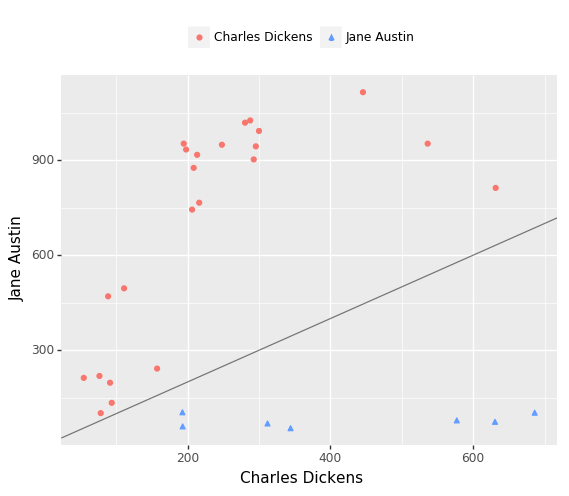

<ggplot: (-9223372036542675270)>


/usr/local/lib/python3.7/site-packages/plotnine/layer.py:517: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  return not cbook.iterable(value) and (cbook.is_numlike(value) or


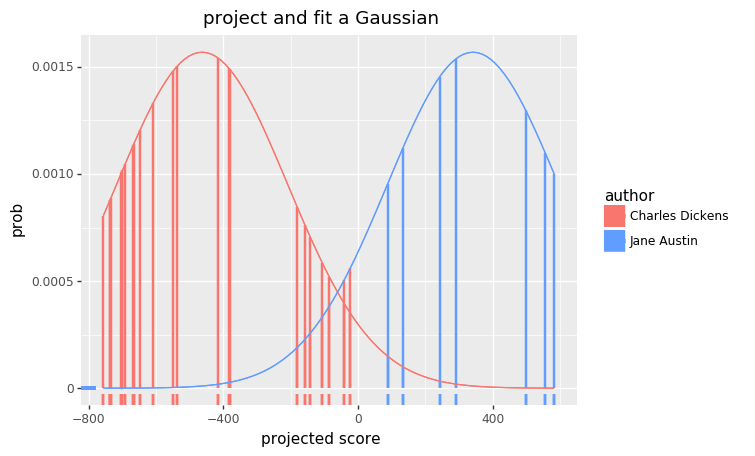

<ggplot: (312934769)>


In [5]:
#compute HC scores of document against each corpus 
df = model.internal_stats()
p = plot_author_pair(df, value = 'HC', wrt_authors=('Charles Dickens', 'Jane Austin'))
print(p)
p = plot_LDA(df, value = 'HC', wrt_authors=('Charles Dickens', 'Jane Austin'), sym = True)\
        + ggtitle('project and fit a Gaussian')
print(p)

<H2>Find distinguishing words or ngrams (features)</H2>

/usr/local/lib/python3.7/site-packages/plotnine/scales/scale.py:549: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


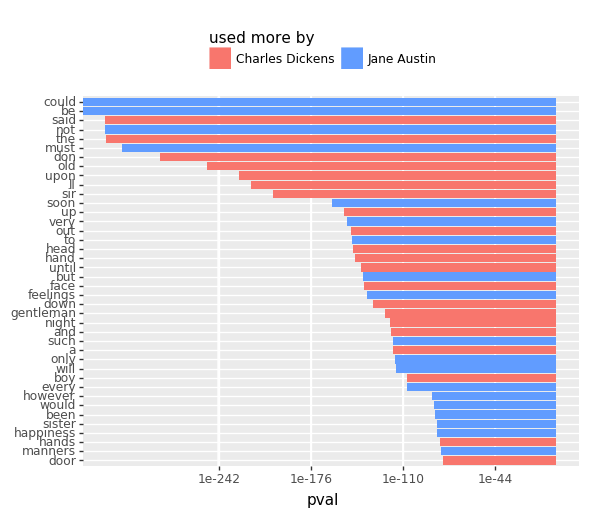

<ggplot: (-9223372036541429795)>


In [6]:
df_pv = model.two_author_test('Charles Dickens','Jane Austin', )

df_desc = df_pv[~np.isnan(df_pv.z)].rename(columns = {'feat':'term'}).sort_values('pval')
p = plot_col(df_desc.head(40), value = 'pval', sign='z', wrt_authors=('Charles Dickens','Jane Austin'))
print(p)

<H2>Reduce model to the set of discriminating features</H2>

In [7]:
feat = model.reduce_features_from_author_pair('Charles Dickens', 'Jane Austin')

Reducing to 1579 features...
Changing vocabulary for Charles Dickens. Found 2592009 relevant tokens.
Changing vocabulary for Jane Austin. Found 400062 relevant tokens.


100%|██████████| 2/2 [01:12<00:00, 37.30s/it]


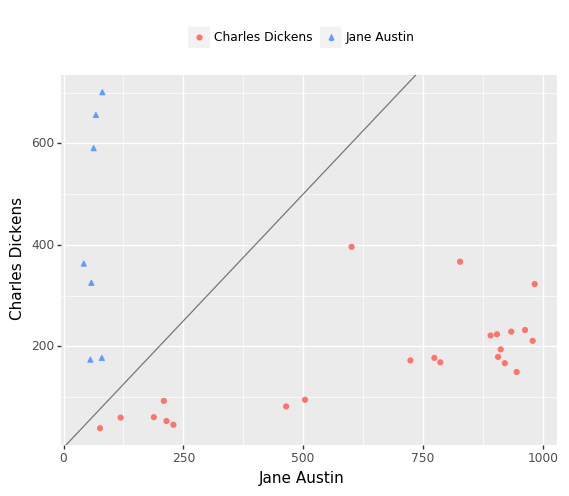

<ggplot: (307069865)>

In [8]:
#compute HC scores of document against each corpus 
df = model.internal_stats()
plot_author_pair(df, value = 'HC', wrt_authors=('Jane Austin', 'Charles Dickens'))

100%|██████████| 2/2 [00:01<00:00,  1.92it/s]


In [15]:
model._stbl

False